# Notebook to plot HNL constraints

This notebook runs through the process of getting the 0-th order constraints from T2K

In [1]:
%load_ext autoreload
%autoreload 2

In [17]:
import numpy as np
from scipy import interpolate

from matplotlib import rc, rcParams
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
import matplotlib.tri as tri

import pathos.multiprocessing as mp
from pathos.multiprocessing import ProcessingPool as Pool

from functools import partial

from particle import *
from particle import literals as lp

In [3]:
from HNL_MC import *
from HNL_MC import hnl_tools

# Neutrino fluxes 

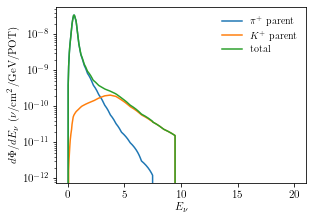

In [4]:
nd280fhc = exp.experiment(exp.ND280_FHC)
fpi = nd280fhc.get_flux_func(parent=lp.pi_plus)
fK = nd280fhc.get_flux_func(parent=lp.K_plus)

fig = plt.figure()
ax = fig.add_axes(plot_style.axes_form)

x=np.linspace(0,20,1000)
ax.plot(x,fpi(x), label='$\pi^+$ parent')
ax.plot(x,fK(x), label='$K^+$ parent')
ax.plot(x,fpi(x) + fK(x), label='total')

ax.set_xlabel(r"$E_\nu$")
ax.set_ylabel(r"$d\Phi/dE_\nu$ ($\nu$/cm$^2$/GeV/POT)")
ax.set_yscale('log')
ax.legend(loc='upper right', frameon=False)
ax.patch.set_facecolor('None')
fig.savefig("plots/nd280_FHC_nufluxes.png", dpi=400)

# Shrock Function

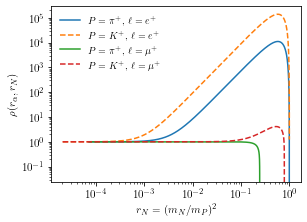

In [5]:
mN_K = np.logspace(-5,np.log10(lp.K_plus.mass/1e3),10000, endpoint=False)
mN_pi = np.logspace(-5,np.log10(lp.pi_plus.mass/1e3),10000, endpoint=False)

fig = plt.figure()
ax = fig.add_axes(plot_style.axes_form)

ax.plot(mN_pi/(lp.pi_plus.mass/1e3), hnl_tools.get_Rapp(mN_pi, parent = lp.pi_plus, daughter = lp.e_plus), label=r'$P=\pi^+,\,\ell=e^+$')
ax.plot(mN_K/(lp.K_plus.mass/1e3), hnl_tools.get_Rapp(mN_K, parent = lp.K_plus, daughter = lp.e_plus), label=r'$P=K^+,\,\ell=e^+$',ls='--')

ax.plot(mN_pi/(lp.pi_plus.mass/1e3), hnl_tools.get_Rapp(mN_pi, parent = lp.pi_plus, daughter = lp.mu_plus), label=r'$P=\pi^+,\,\ell=\mu^+$')
ax.plot(mN_K/(lp.K_plus.mass/1e3), hnl_tools.get_Rapp(mN_K, parent = lp.K_plus, daughter = lp.mu_plus), label=r'$P=K^+,\,\ell=\mu^+$',ls='--')

ax.set_ylabel(r"$\rho(r_\alpha,r_N)$")
ax.set_xlabel(r"$r_N=(m_N/m_P)^2$")
ax.set_yscale("log")
ax.set_xscale("log")
ax.legend(loc='upper left', frameon=False)
ax.patch.set_facecolor('None')
fig.savefig("plots/rho_function.png", dpi=400)

# Approximation for HNL flux

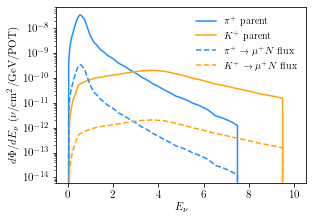

In [6]:
fig = plt.figure()
ax = fig.add_axes(plot_style.axes_form)

x=np.linspace(0,10,1000)
MN = 0.01
USQR = 1e-2


phiN_pi = hnl_tools.dphi_dEN_app(fpi, x, Ualpha4SQR=USQR, mN=MN, parent=lp.pi_plus, daughter=lp.mu_plus)
phiN_K = hnl_tools.dphi_dEN_app(fK, x, Ualpha4SQR=USQR, mN=MN, parent=lp.K_plus, daughter=lp.mu_plus)

ax.plot(x,fpi(x), label=r'$\pi^+$ parent', color= 'dodgerblue')
ax.plot(x,fK(x), label=r'$K^+$ parent', color='orange')

ax.plot(x,phiN_pi, label=r'$\pi^+ \to \mu^+ N$ flux', ls='--', color= 'dodgerblue')
ax.plot(x,phiN_K, label=r'$K^+  \to \mu^+ N$ flux', ls='--', color='orange')

ax.set_xlabel(r"$E_\nu$")
ax.set_ylabel(r"$d\Phi/dE_\nu$ ($\nu$/cm$^2$/GeV/POT)")
ax.set_yscale('log')

ax.legend(loc='upper right', frameon=False)
ax.patch.set_facecolor('None')
fig.savefig("plots/HNL_fluxes_mN_150.png", dpi=400)

# Decay Rates

In [7]:
UMU4 = np.sqrt(1e-4)
my_hnl = model.hnl_model(m4=0.120, mixings=[0.0,UMU4, 0.0])
my_hnl.set_high_level_variables()
my_hnl.compute_rates()

## Ue4

In [70]:
# Compute all the decay rates and branching ratios
M4=np.logspace(-2,np.log10(0.300),100)
USQR = 1e-6
ctaus=[]
for j in range(len(M4)):
    my_hnl = model.hnl_model(m4=M4[j], mixings=[np.sqrt(USQR),0, 0.0])
    my_hnl.set_high_level_variables()
    my_hnl.compute_rates()
    ctaus.append(my_hnl.ctau0)
ctaus=np.array(ctaus)

No handles with labels found to put in legend.


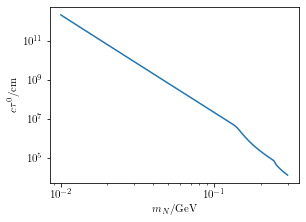

In [71]:
fig = plt.figure()
ax = fig.add_axes(plot_style.axes_form)

ax.plot(M4,ctaus)
 
ax.set_xlabel(r"$m_N$/GeV")
ax.set_ylabel(r"$c\tau^0/$cm")
ax.set_xscale('log')
ax.set_yscale('log')
# ax.set_ylim(1e-5,1)
ax.legend(loc='lower left', frameon=False, ncol=1,fontsize=9)
ax.patch.set_facecolor('None')
fig.savefig("plots/lifetime_e-only.png", dpi=400)

In [15]:
# Compute all the decay rates and branching ratios
M4=np.logspace(-2,np.log10(0.300),100)
USQR = 1e-2

list_of_channels = ['nu_nu_nu','nu_e_e','nu_e_mu','nu_mu_mu','nu_pi','e_pi','mu_pi']
all_brs = np.empty((len(list_of_channels),len(M4)))

for j in range(len(M4)):
    my_hnl = model.hnl_model(m4=M4[j], mixings=[np.sqrt(USQR),0.0, 0.0])
    my_hnl.set_high_level_variables()
    my_hnl.compute_rates()
    for channel in list_of_channels:
        
        i = list_of_channels.index(channel)
        
        if channel in my_hnl.brs:
            all_brs[i,j] = my_hnl.brs[channel]
        else:
            all_brs[i,j] = 0.0

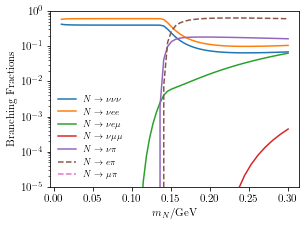

In [16]:
fig = plt.figure()
ax = fig.add_axes(plot_style.axes_form)

for channel in list_of_channels:
    i = list_of_channels.index(channel)
    label=f'$N\\to {channel}$'.replace("_", " ").replace("nu", '\\nu').replace("mu", '\\mu').replace("pi", '\\pi')
    
    if channel[:2] != "nu":
        s='--'
    else:
        s='-'
    
    ax.plot(M4, all_brs[i,:], label=label, linestyle=s)
            
ax.set_xlabel(r"$m_N$/GeV")
ax.set_ylabel(r"Branching Fractions")
ax.set_yscale('log')
ax.set_ylim(1e-5,1)
ax.legend(loc='lower left', frameon=False, ncol=1,fontsize=9)
ax.patch.set_facecolor('None')
fig.savefig("plots/Branching_ratios_e-only.png", dpi=400)

## Umu4

In [72]:
# Compute all the decay rates and branching ratios
M4=np.logspace(-2,np.log10(0.300),100)
USQR = 1e-2
ctaus=[]
for j in range(len(M4)):
    my_hnl = model.hnl_model(m4=M4[j], mixings=[0.0,np.sqrt(USQR), 0.0])
    my_hnl.set_high_level_variables()
    my_hnl.compute_rates()
    ctaus.append(my_hnl.ctau0)
ctaus=np.array(ctaus)

No handles with labels found to put in legend.


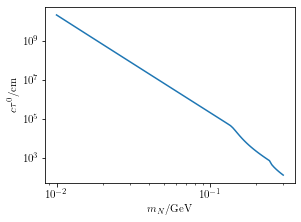

In [73]:
fig = plt.figure()
ax = fig.add_axes(plot_style.axes_form)

ax.plot(M4,ctaus)
 
ax.set_xlabel(r"$m_N$/GeV")
ax.set_ylabel(r"$c\tau^0/$cm")
ax.set_xscale('log')
ax.set_yscale('log')
# ax.set_ylim(1e-5,1)
ax.legend(loc='lower left', frameon=False, ncol=1,fontsize=9)
ax.patch.set_facecolor('None')
fig.savefig("plots/lifetime_mu-only.png", dpi=400)

In [17]:
# Compute all the decay rates and branching ratios
M4=np.logspace(-2,np.log10(0.300),100)
USQR = 1e-2

list_of_channels = ['nu_nu_nu','nu_e_e','nu_e_mu','nu_mu_mu','nu_pi','e_pi','mu_pi']
all_brs = np.empty((len(list_of_channels),len(M4)))

for j in range(len(M4)):
    my_hnl = model.hnl_model(m4=M4[j], mixings=[0.0,np.sqrt(USQR), 0.0])
    my_hnl.set_high_level_variables()
    my_hnl.compute_rates()
    for channel in list_of_channels:
        # Compute all the decay rates and branching ratios
M4=np.logspace(-2,np.log10(0.300),100)
USQR = 1e-6
ctaus=[]
for j in range(len(M4)):
    my_hnl = model.hnl_model(m4=M4[j], mixings=[0.0,np.sqrt(USQR), 0.0])
    my_hnl.set_high_level_variables()
    my_hnl.compute_rates()
    ctaus.append(my_hnl.ctau0)
ctaus=np.array(ctaus)

fig = plt.figure()
ax = fig.add_axes(plot_style.axes_form)

ax.plot(M4,ctaus)
 
ax.set_xlabel(r"$m_N$/GeV")
ax.set_ylabel(r"$c\tau^0/$cm")
ax.set_xscale('log')
ax.set_yscale('log')
# ax.set_ylim(1e-5,1)
ax.legend(loc='lower left', frameon=False, ncol=1,fontsize=9)
ax.patch.set_facecolor('None')
fig.savefig("plots/lifetime_mu-only.png", dpi=400)
        i = list_of_channels.index(channel)
        
        if channel in my_hnl.brs:
            all_brs[i,j] = my_hnl.brs[channel]
        else:
            all_brs[i,j] = 0.0

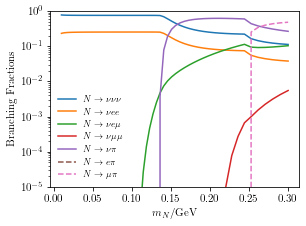

In [18]:
fig = plt.figure()
ax = fig.add_axes(plot_style.axes_form)

for channel in list_of_channels:
    i = list_of_channels.index(channel)
    label=f'$N\\to {channel}$'.replace("_", " ").replace("nu", '\\nu').replace("mu", '\\mu').replace("pi", '\\pi')
    
    if channel[:2] != "nu":
        s='--'
    else:
        s='-'
    
    ax.plot(M4, all_brs[i,:], label=label, linestyle=s)
            
ax.set_xlabel(r"$m_N$/GeV")
ax.set_ylabel(r"Branching Fractions")
ax.set_yscale('log')
ax.set_ylim(1e-5,1)
ax.legend(loc='lower left', frameon=False, ncol=1,fontsize=9)
ax.patch.set_facecolor('None')
fig.savefig("plots/Branching_ratios_mu-only.png", dpi=400)

# Compute number of decays in TPCs

In [158]:
# tests
hnl_tools.get_event_rate((0.300, 1e-6), flavor_struct=[0.0,1.0,0.0], exp_setup=exp.ND280_FHC)
# print(hnl_tools.get_lifetime((0.150, 1e-0), flavor_struct=[0.0,0.0,1.0]))
# print(hnl_tools.get_lifetime((0.300, 1e-0), flavor_struct=[0.0,0.0,1.0]))

3441.608266799846

## Batch computation

In [172]:
# grid of mix vs mass
gridx = 60
gridy = 40

M4 = np.logspace(np.log10(0.01), np.log10(0.500), gridx)
USQR = np.logspace(-10,-2, gridy) 
X,Y = np.meshgrid(M4,USQR)
m4_grid, usqr_grid = X.flatten(), Y.flatten()

# run event rate calc ß


tot_cores = mp.cpu_count()
pool = Pool(tot_cores)
############

get_event_partial = partial(hnl_tools.get_event_rate, flavor_struct=[0.0,1.0,0.0], exp_setup = exp.ND280_FHC)
event_rate = pool.map(get_event_partial, ((m4, usqr) for m4, usqr in zip(m4_grid, usqr_grid)))

get_lifetime_partial = partial(hnl_tools.get_event_rate, flavor_struct=[0.0,1.0,0.0])
lifetime = pool.map(hnl_tools.get_lifetime, ((m4, usqr) for m4, usqr in zip(m4_grid, usqr_grid)))

############
pool.terminate()
pool.restart()

<multiprocess.pool.Pool state=RUN pool_size=8>

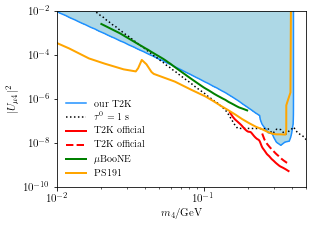

In [176]:
fig = plt.figure()
ax = fig.add_axes(plot_style.axes_form)
ax.patch.set_facecolor('None')

# T2K estimate
Xi,Yi,Zi=plot_style.interp_grid(x=m4_grid, y=usqr_grid , z=event_rate, fine_gridx=gridx, fine_gridy=gridy, log=True)
# get contour x and y
_ = ax.contourf(Xi, Yi, Zi, levels = [2.3,1e100], colors=['lightblue']) #NEW CONSTRAINT
level_0 = ax.contour(Xi, Yi, Zi, levels = [2.3], colors=['None']) #NEW CONSTRAINT
bound = level_0.collections[0].get_paths()[0].vertices  #grab the coords of the bound
ax.plot(bound[:,0],bound[:,1], c='dodgerblue', label=r'our T2K')

# ctau = 0.1 s
Xi,Yi,Zi=plot_style.interp_grid(x=m4_grid, y=usqr_grid , z=lifetime, fine_gridx=gridx, fine_gridy=gridy, log=True)
level_1 = ax.contour(Xi, Yi, Zi, levels = [0.1*const.c_LIGHT], colors=['None'], linestyles=['--']) #NEW CONSTRAINT
bound = level_1.collections[0].get_paths()[0].vertices  #grab the coords of the bound
ax.plot(bound[:,0],bound[:,1], c='black', ls=':', label=r'$\tau^0 = 1$ s')

# T2K bound
mbound,ubound = np.genfromtxt('digitized/T2K_2019/T2K_2019_mu.dat',unpack=True)
plt.plot(mbound/1e3,ubound, c='red', lw=2, label='T2K official')
mbound,ubound = np.genfromtxt('digitized/T2K_2019/T2K_2019_mu_single_channel.dat',unpack=True)
plt.plot(mbound/1e3,ubound, c='red', lw=2, ls='--', label='T2K official')

# Kelly Machado 
mbound,ubound = np.genfromtxt('digitized/muboone_kelly_machado/PS_eff_scalar.dat',unpack=True)
plt.plot(mbound/1e3,ubound, c='green', lw=2, ls='-', label='$\mu$BooNE')
# mbound,ubound = np.genfromtxt('digitized/muboone_kelly_machado/PS_eff_avg.dat',unpack=True)
# plt.plot(mbound/1e3,ubound, c='green', lw=2, ls='--', label='Kelly \& Machado')

# Kusenko
mbound,ubound = np.genfromtxt('digitized/Kusenko/Umu4_v2.dat',unpack=True)
plt.plot(mbound/1e3,ubound, c='orange', lw=2, ls='-', label='PS191')


ax.set_yscale("log")
ax.set_xscale("log")

ax.set_ylabel("$|U_{\mu 4}|^2$")
ax.set_xlabel("$m_4/$GeV")

ax.legend(loc='lower left', frameon=False, ncol=1)
ax.set_ylim(1e-10,1e-2)
ax.set_xlim(1e-2,0.5)
fig.savefig('plots/T2K_bound.png',dpi=400)

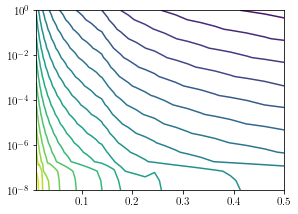

In [97]:
plt.contour(Xi,Yi,np.log10(Zi),levels=20)
plt.yscale("log")